# Tweet Like Trump - An Introduction to Markov Chains

## Overview:

This tutorial gives a demonstration of how to create a Twitter Bot that uses Markov Chains to generate its text. Markov Chains allow us to create a model of a lanugage in order to statistically generate what a language would be. Using the Markov model has several applications in text processing including text generation, information retrieval, data compression, and spam filtering. There are also applications in gene prediction and Google's Page Rank. In this tutorial, we will be learning how to create a model using a corpus text and then using this model to generate tweets for your very own Twitter bot. 

Twitter bots can be used to generate automatic replies or updates for various reasons. Examples include the @tinycarebot which promotes self care and the @EarthquakesSF which generates updates on earthquakes in the San Francisco Bay Area as they happen using real-time seismographic information. 

### How a Markov Chain Works:


<img src="files/markovex.png">


A Markov Chain is a probabilistic model that gives probabilities to transitions from different states. In the image above, the Markov Chain is represented as a graphic where each circle represents a state and the probability of transitioning from one state to the other is represented by the decimal numbers. In the model above, if you begin in state 'A', the probability of you moving to state 'E' is 40% (.4) and the probability of you stayiing in the same state i 60% (.6). 

Any Markov Chain is often be represented as a matrix where each M_ij for index i and j represent the probability of going from state i to j. The matrix for the above Markov Chain is shown below. 


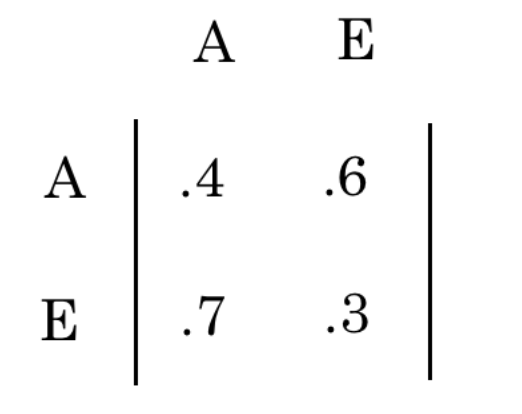



Because we are focusing on practical applications of Because we are going to be using python to store our data, we are going to actually use python dictionaries to store our probabilities (more on this later).

The intuition behind using Markov Chains for generating text is that some words have a high probability of appearing after the English language (or any language in general). For example the probability of the word "Chain" occuring after the word "Markov" is extremely high, whereas the probability of the word "sunshine" occuring after "Markov" is near impossible, especially if using training data. 



## Tutorial Content 

1. [Installing the Libraries](##Installing-the-Libraries)
2. [Setting up the Corpus Text](##Setting-Up-the-Corpus-Text)
3. [Creating the Markov Model](##Creating-the-Markov-Model)
4. [Generating Text](##Generating-Text)
5. [Adjusting Weights](##Adjusting-Weights)
6. [Tweeting Your Results](##Tweeting-Your-Results)



## Installing the Libraries


This tutorial will be using two standard libraries: re and random, which you can directly import. We will also be using the Tweepy library in order to tweet our generated text. 

In order to get the tweepy library, make sure you have [pip](https://pip.pypa.io/en/stable/installing/) installed and run: 

```  $ pip install tweepy
```



In [62]:
import re
import random
import tweepy

# Creating and Training Your Model

## Setting Up the Corpus Text

A corpus text is a large chunk of text that can be used to validate certain linguistic rules. In this tutorial, we will be using a compilation of Donald Trump's speeches for our corpus text. Theoretically, this should allow us to generate text that uses vocabulary and tone specific to Donald Trump. 

In order to prepare our corpus we open our text file (included in this folder) and grab it's contents:

In [63]:
def get_content(file_name):
    myfile = file_name #replace this with any other corpus text file

    with open(myfile, "rt") as fileContents:
        content = fileContents.read()
        fileContents.close()
    return content
    
content = get_content("trump.txt") 
#print(content) #uncomment to see all the text in the file 


Once you un-comment the print statement above, you may notice several unecessary tabs, spaces, and newline characters. 

We must remove the extra whitespaces so that our model doesn't recognize these different characters as unique words. Without doing this step, our text generator could potentially add arbitary white spaces after certain words in our tweets. 

the ```format_data``` function cleans up our text so that it is ready to train. This is an extremely important step because it reduces unneeded and potentially incorrect that might skew the results of our text generator. 

In [64]:
def format_data(content):
    re.sub('\s+',' ', content)  #remove tabs + extra spaces 
    content = content.replace('\n', ' ').replace('\r', '') #remove new lines
    content = content.strip() #remove trailing spaces
    return content

content = format_data(content)
#print(content)


## Creating the Markov Model

Finally - the exciting part! Often, training any model may often require several iterations and may require different parameters and sepcifications for different iterations of each training. 

For example, if you notice that lately, Donald Trump has been using a lot of alliterations in his tweets, you may want to increase the probability of a certain word based on the previous word's first letter. This is called applying a fitness function and will be discussed later when we add our fitness functions. 

Because our model will consistently be changing, we want to define a class that stores our Markov Model which will be represented by a tree-like data structure. 



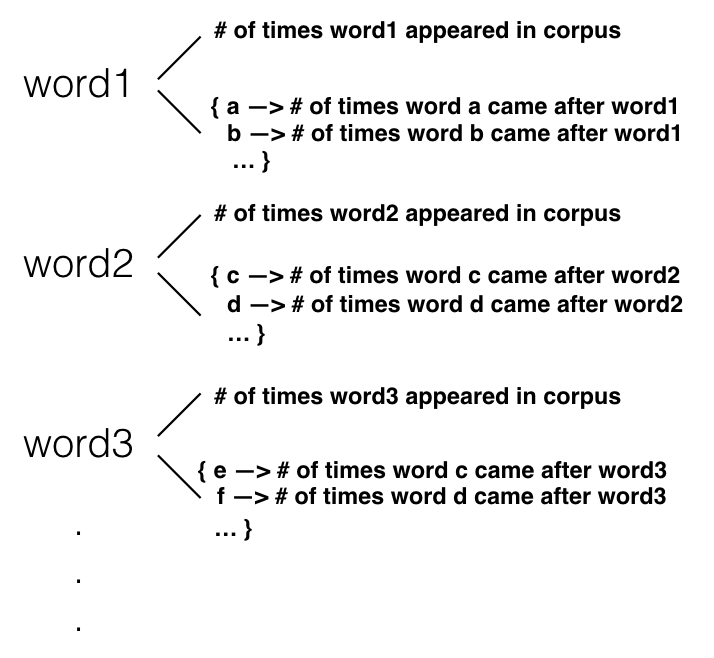


This is represented by the ```tree``` variable which is a dictionary containing a key of type ```str``` and a value of type ```(int, dict())```. 

We also store any word that may start a sentence in ```starterWords```. This is useful later when we want to generate more realistic sentences. 


In [65]:
class MarkovModel:
    
    def __init__(self):
        # contains our markov model
        self.tree = dict() 
        # a set of words that may be found at the beginning of sentences based on our corpus 
        self.starterWords = set()

    def train(self, text, punctuation = ".!?"): 
        words = [w for w in text.split(" ")]
        # Add the first word in our corpus to our starter words
        self.starterWords.add(text[0]) 
        # For every pair of words in the corpus - a, b: 
        for a, b in [(words[i], words[i + 1]) for i in range(len(words) - 1)]:
            # If b contains some punctuation at its end and a begins with a capital letter, we must've reached the end of a sentence
            if (len(b) > 0 and b[0].isupper() and len(a) > 0 and a[-1] in punctuation):
                # Add the word b to starterWords 
                self.starterWords.add(b)
            
            # Create a key for a word that hasn't appeared in the corpus before and set its count to 1
            if a not in self.tree:
                self.tree[a] = (1, dict())
            # Otherwise, add 1 to the count of that word
            else:
                self.tree[a] = (self.tree[a][0] + 1, self.tree[a][1])
                
            # If b has never appeared after a, then create a key for b in a's successor dictionary
            if b not in self.tree[a][1]:
                self.tree[a][1][b] = 1
            #Otherwise increase b's count in a's successor dictionary
            else:
                self.tree[a][1][b] +=1

    
m = MarkovModel()
m.train(content)
#print(m.tree)

## Generating Text

We now create our generate function. This function will use the model we just created with our corpus text to generate probabilities for a potential successor word coming after a word we have chosen. After generating these probabilities we will use the random library to generate each next word using these probabilites. 

In the previous section, we have created a set of potential starter words which we use to start our sentence in case a valid one isn't provided. After choosing this word, we start chaining our sentence together using the probabilities we collected while training. 

In [90]:
# Helper function to choose a key based on it's values representing a weight. 
# e.g. {"sun": .25, "moon" .75} will output "moon" with a 75% chance, and "sun" with a 25% chance

# Inspired by https://stackoverflow.com/questions/1056151/random-python-dictionary-key-weighted-by-values
def weighted_random_by_dct(dct):
    rand_val = random.random() # gets random value between 0 and 1
    total = 0
    for k in dct:
        total += dct[k]
        if rand_val <= total:
            return k
    return None

# Generate function, takes in markov object m. 
# Allows you to specify what you characterize as a punctuation mark that neds a sentences (sentenceStoppers)
# Lets you specify the number of sentences you want and the number of characters that your sentences can contain all together (num_sentences, chars) 
def generate(m, startingWord = None, sentenceStoppers = ".?!", num_sentences = 1, chars = 280):
    sentences = []
    for i in range(num_sentences):
        tweet = ""
        if startingWord == None:
            # randomly choose from dictionary
            start = random.sample(m.starterWords, 1)[0]
        else:
            if(start not in m.starterWords):
                print("Please choose a valid starting word") 
                return None
            start = startingWord
            
        tweet += start
        
        # Keep looping until we get a word that ends in a punctuation mark. 
        while(start[-1] not in sentenceStoppers):
            # Create our probability dictionary for the current word we want to succeed. 
            prob_dict = dict()
            # For each potential successor word b, divide the number of times it appeared 
            # by the total number of times the current word appeared in the corpus
            for k in m.tree[start][1]:
                prob_dict[k] = m.tree[start][1][k]/m.tree[start][0]
            # Choose our next word randomly based on probabilities
            start = weighted_random_by_dct(prob_dict)
            tweet += " " + start
            if(start == ""):
                break
            
        sentences.append(tweet)
    
    final_tweet = ""
    currCharLen = 0
    # Sometimes our char limit might restrict the number of generated sentences we can use for our tweet
    # We make sure we only add enough sentences to satisfy this limit.
    while(currCharLen < chars and len(sentences) > 0):
        add = sentences.pop(0)
        length = len(add)
        final_tweet += add
        currCharLen += length
        
    return final_tweet
        
# We can test and see what kinds of sentences our markov model is generating here.
m = MarkovModel()
m.train(content)
g = generate(m)
# print(g)

    

## Adjusting Weights to Tweak your Model 

Remember when we mentioned that we may want to continuously make tweaks to our model? We create the adjust_weights function in order to allow us to pass in fitness functions - small lambda functions that we can create to increase or decrease weights for a certain property. 

Our adjust_weights would better fit inside the MarkovModel class but we have defined it separately because of Jupyter Notebook's limitations. The function takes in our model and a piece of generated text. It then uses the fitness function to determine whether the weight of a certain successor word should be increased or decreased. 


In [91]:
def adjust_weights(m, f=lambda a, b: 0, iterations = 1):
    for i in range(iterations):
        text = generate(m)
        words = [w.lower() for w in text.split()]
        pairs = []
        factors = []
        for i in range(len(pairs)-1):
            a = pairs[i]
            b = pairs[i+1]
            factors.append((a,b))
        for (a,b) in pairs:
            # If our factor returned by f is larger than .5 then we will be increasing our probability, 
            # otherwise we wil be decreasing it:
            factors.append(f(a,b) - 0.5 * 2) 
        for i in range (len(pairs)):
            if factors[i] < -1 or factors[i] > 1:
                continue
            # train the text on the pair of words given the factor we just calculated. 
            m.train(pairs[i][0] + " " + pairs[i][1], factors[i])
        

### Fitness Functions

Here, we have defined some fitness functions that might be interesting to use in our model. 

In this tutorial, a fitness function takes 

For example, ```complexity_fitness``` looks at the number of unique characters in a & b and divides it by the number of characters in total. Therefore, if you have all unique characters between a and b, you get a factor of 1.0 which make both a & b great candidates for 'complex' words. 

```simplicty_fitness``` is simply the complement of ```complexity_fitness```. 

In [92]:
# Some fitness functions:

def complexity_fitness(a, b):
    s = set()
    for x in a+b:
        s.add(x) 
    return len(s)/(len(a + b))*1.0

def simplicty_fitness(a, b):
    return 1 - complexity_fitness(a, b)

def complexity_mix_fitness(a, b):
    return (simplicity_fitness(b, b) + complexity_fitness(a, a)) / 2

def vowels_fitness(a, b):
    total = 1
    for x in a+b:
        if x in "aeiou":
            total+=1
    return total/(len(a+b)*1.0)

def consonants_fitness(a, b):
    return 1 - vowels_fitness(a, b)

# Feel free to define more fitness functions!

We can now train our model a little further using some of our fitness functions:

In [93]:
adjust_weights(m, complexity_mix_fitness, 1000)
g = generate(m)
print(g)

Deals are going to clean up the country.


## Tweeting Your Results 

Finally! We're on the home stretch. Now we can finally start tweeting our generated sentences. 

Create a twitter account that will be posting the tweets for you. In order to do this:

1. Create a [Twitter](https://twitter.com/) account.

2. [Create a New App](apps.twitter.com )

3. The access level should be set to "Read and write" otherwise, click "modify app permissions"

4. Go to "manage keys and access tokens" to see your API client and secret keys, as well as your access token and access token secret.


Assign the following variables with *your* respective tokens:

In [94]:
CONSUMER_KEY = "" # Consumer Key (API Key) 
CONSUMER_SECRET = "" # Consumer Secret (API Secret)
ACCESS_TOKEN = "" # Access Token
TWITTER_ACCESS_SECRET = "" # Access Token Secret

Here is a quick test to make sure your tokens are correct and Tweepy is running correctly. Make sure this function works before creating your main function.

In [95]:
def tweepy_tweet(text):
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth)

    try:
        api.update_status(text)
    except TweepyError:
        print("Could not tweet")

        
# tweepy_tweet("Hello, world!")

If the function works correctly, then your twitter account should have tweeted "Hello, world!". If not, see debbuging help [here](http://tweepy.readthedocs.io/en/v3.5.0/). 

In [98]:
def main():
    file = "trump.txt"
    m = MarkovModel()
    c = get_content(file)
    c = format_data(c)
    m.train(c)
    adjust_weights(m, complexity_mix_fitness, 1000)
    g = generate(m)
    tweepy_tweet(g)
    
main()

## Result:

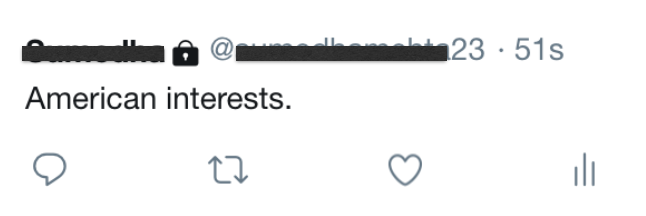


### Wrap Up 

You have now successfully tweeted like Donald Trump! You may have noticed that the Markov model certainly has it's limitations because it is simply attempting to mimic the corpus text. The larger and more varied your corpus text is, the more likely you are to generate language that resembles English. 


### Further Reading & References


1. [Other Applications of Markov Chains](http://langvillea.people.cofc.edu/MCapps7.pdf)
2. [Fitness Functions](https://en.wikipedia.org/wiki/Fitness_function)
3. [Improving the performance of Markov Chains](https://projecteuclid.org/euclid.ss/1015346319)
4. [Tweepy](http://www.tweepy.org/)
